# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
from pandas.api import types as pdt
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression # Modelo de Decisão
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor # Modelo de Decisão
from sklearn.model_selection import train_test_split # machine_learning
# Modelo Regressor serve para Decisão!

### Consolidar Base de Dados

### Agora vamos importar as bases de dados

Para isso, vamos criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

Para cada arquivo da base de dados a gente vai importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [ ]:
meses = {
    'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4,
    'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8,
    'set': 9, 'out': 10, 'nov': 11, 'dez': 12
}

# mapeamento completo de nomes extensos ou errados para abreviações corretas
abreviados = {
    'janeiro': 'jan', 'fevereiro': 'fev', 'marco': 'mar', 'março': 'mar',
    'abril': 'abr', 'maio': 'mai', 'junho': 'jun', 'julho': 'jul',
    'agosto': 'ago', 'setembro': 'set', 'outubro': 'out',
    'novembro': 'nov', 'dezembro': 'dez'
}

caminho_bases = pathlib.Path('dataset/dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    df = pd.read_csv(arquivo, low_memory=False, encoding='latin-1')

    # extrai e padroniza o nome do mês
    nome_completo_mes = ''.join([c for c in arquivo.name if not c.isdigit()]).replace('.csv', '').lower()
    nome_mes_abreviado = abreviados.get(nome_completo_mes[:len(nome_completo_mes)], nome_completo_mes[:3])
    df['mes'] = meses[nome_mes_abreviado]  # converte para número

    # extrai o ano dos 4 dígitos antes de ".csv"
    ano = int(arquivo.name[-8:-4])
    df['ano'] = ano

    # concatena no DataFrame geral
    base_airbnb = pd.concat([base_airbnb, df], ignore_index=True)


# filtrar só as colunas importantes
df_airbnb = base_airbnb[[
    'host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'bed_type', 'amenities', 'price', 'guests_included',
    'extra_people', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'instant_bookable', 'is_business_travel_ready',
    'cancellation_policy', 'mes', 'ano'
]]

# exibir resultado
display(df_airbnb.head())



,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,mes,ano
0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,$34.00,60,365,38,f,f,strict_14_with_grace_period,4,2018
1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,2.0,...,2,$51.00,4,90,205,t,f,strict,4,2018
2,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,1.0,1.0,...,2,$215.00,3,90,85,f,f,strict,4,2018
3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,2,$45.00,4,30,208,f,f,strict,4,2018
4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,2,$68.00,2,1125,200,t,f,strict,4,2018


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

### Agora vamos começar os tratamentos

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [3]:
display(df_airbnb['is_business_travel_ready'])

0         f
1         f
2         f
3         f
4         f
         ..
902205    f
902206    f
902207    f
902208    f
902209    f
Name: is_business_travel_ready, Length: 902210, dtype: object

In [4]:
    # Importar para o computador as colunas para ficar visualmente melhor;

base_airbnb.to_csv('teste.csv', sep=';', index=False, encoding='latin-1')
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';', index=False, encoding='latin-1')

In [ ]:
    # ANTES DE PEGAR OS DADOS DO QUE REALMENTE PRECISO
# print(df_airbnb[['experiences_offered']].value_counts())
# print(df_airbnb[['host_acceptance_rate']].value_counts())
    # Porcentagem que qntd de pessoas deu (11 pessoas deu 6%)

In [ ]:
    # ANTES DE PEGAR OS DADOS DO QUE REALMENTE PRECISO
#print((df_airbnb['host_listings_count'] == df_airbnb['host_total_listings_count']).value_counts())
    # SIGNIFICA que o host_listings_count tem 460 itens de diferença
    # NÃO USAREI ESTA COLUNA!

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [5]:
for coluna in df_airbnb:
    if df_airbnb[coluna].isnull().sum() > 300000:
        df_airbnb = df_airbnb.drop(coluna, axis=1)
# Verificar cada coluna, e se a coluna estiver com MAIS de 300 mil valores vazios, ele simplesmente deleta a coluna inteira.
print(df_airbnb.isnull().sum())
print(df_airbnb.shape)

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
mes                            0
ano                            0
dtype: int64
(902210, 23)


In [6]:
df_airbnb = df_airbnb.dropna()

print(df_airbnb.shape)
print(df_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
mes                         0
ano                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [7]:
print(df_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object


In [8]:
print(df_airbnb.iloc[0])

host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

In [9]:
# Garantir que estamos usando a cópia:
df_airbnb_copy = df_airbnb.copy()
#price
df_airbnb_copy['price'] = df_airbnb_copy['price'].astype(str).str.replace('$', '', regex=False)
df_airbnb_copy['price'] = df_airbnb_copy['price'].str.replace(',', '', regex=False)
df_airbnb_copy['price'] = df_airbnb_copy['price'].astype(np.float32, copy=False)

#extra_people
df_airbnb_copy['extra_people'] = df_airbnb_copy['extra_people'].astype(str).str.replace('$', '', regex=False)
df_airbnb_copy['extra_people'] = df_airbnb_copy['extra_people'].str.replace(',', '', regex=False)
df_airbnb_copy['extra_people'] = df_airbnb_copy['extra_people'].astype(np.float32, copy=False)

#verificando os tipos
print(df_airbnb_copy.dtypes)
print(df_airbnb_copy['price'].dtypes)
print(df_airbnb_copy['extra_people'].dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object
float32
float32


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

<Axes: >

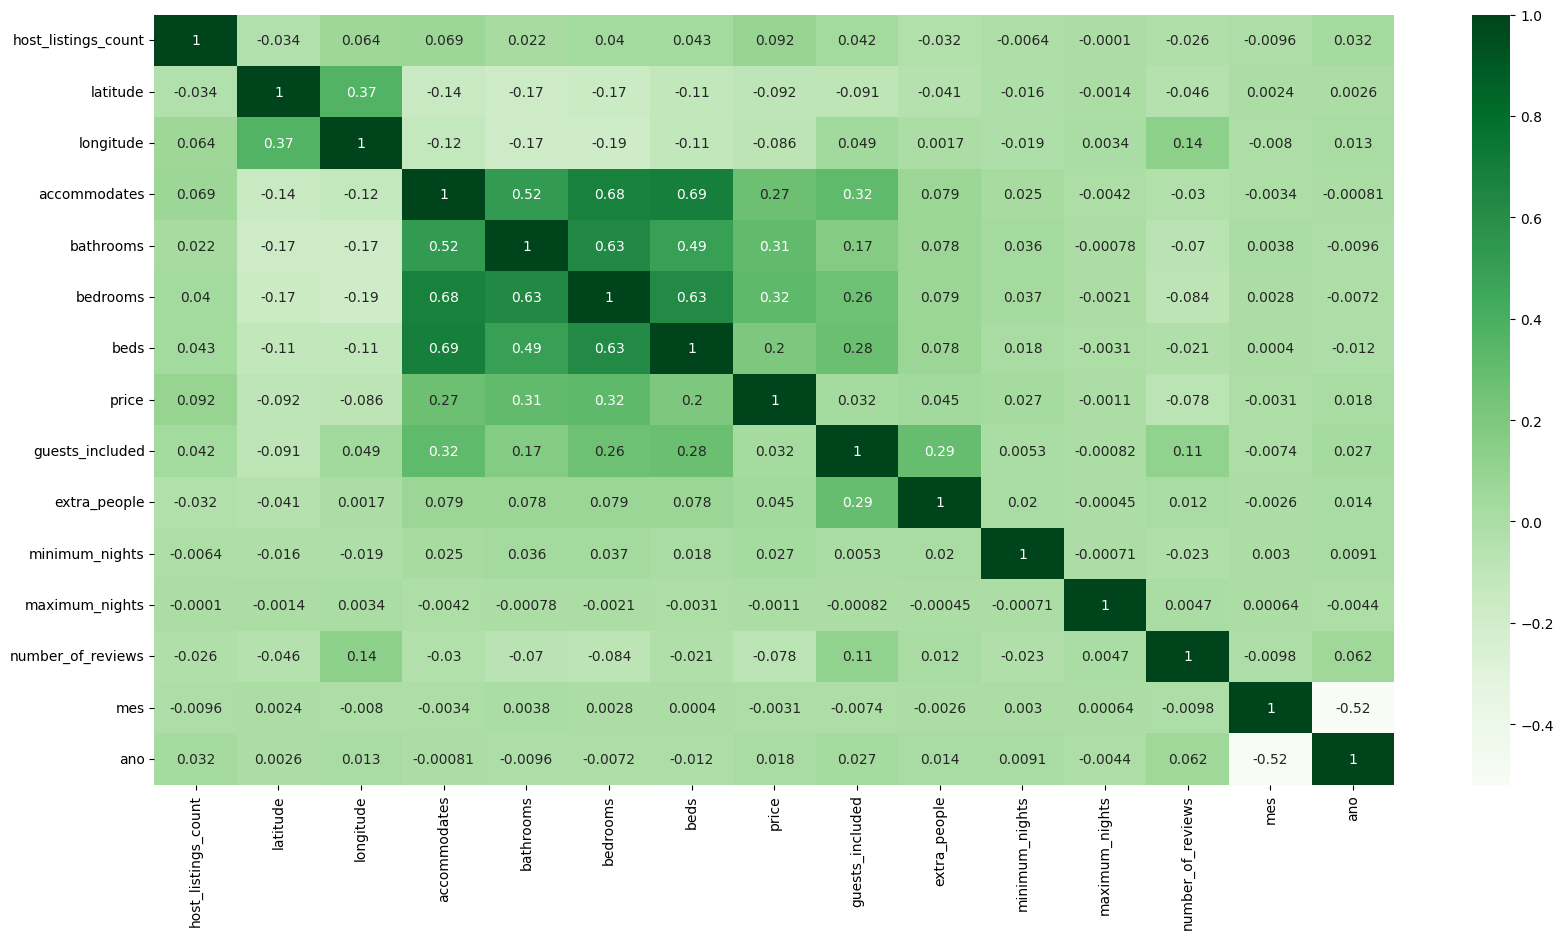

In [10]:
# Mapa de Calor para Correlação
plt.figure(figsize=(20,10))
sns.heatmap(df_airbnb_copy.select_dtypes(include='number').corr(), annot=True, cmap='Greens')
# print(df_airbnb.select_dtypes(include='number').corr())

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [11]:
# valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude

def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [12]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    plt.show
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.histplot(coluna, kde=True)
    ax.set_xlim(limites(coluna))

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price

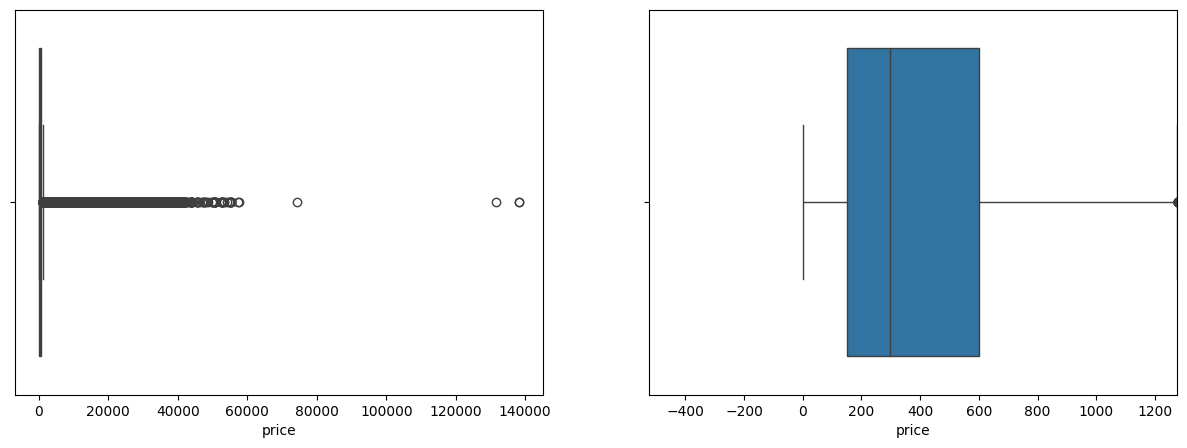

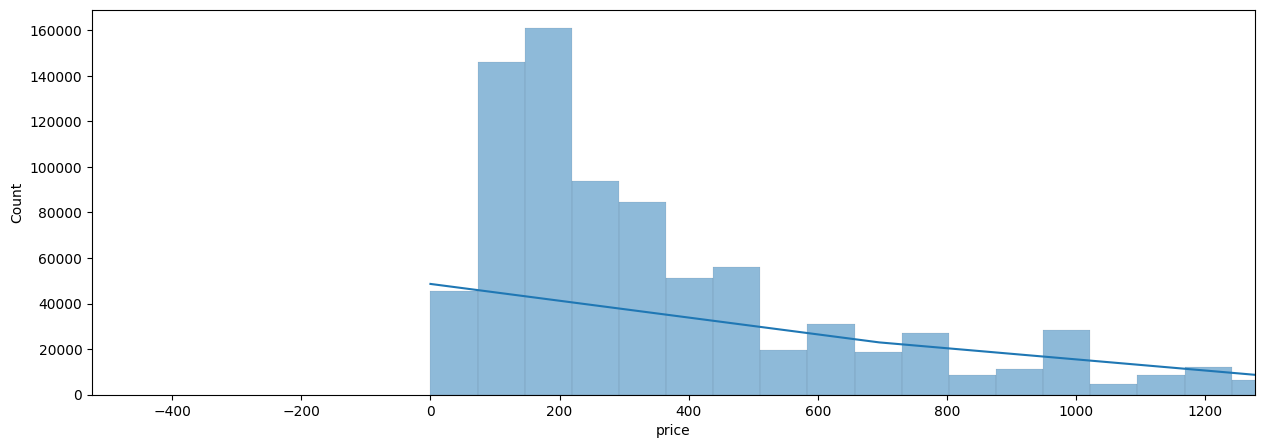

In [13]:
diagrama_caixa(df_airbnb_copy['price'])
histograma(df_airbnb_copy['price'])

# 1 GRÁFICO: MOSTRA NO GERAL DE TODA TABELA;
# 2 GRÁFICO: MOSTRA DENTRO DO LIMITE DE TODA TABELA; 
# 3 GRÁFICO: IGUAL DO PRIMEIRO MAS EM CAIXA;

Como estamos construindo um modelo para imóveis COMUNS, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [14]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


(810427, 23)


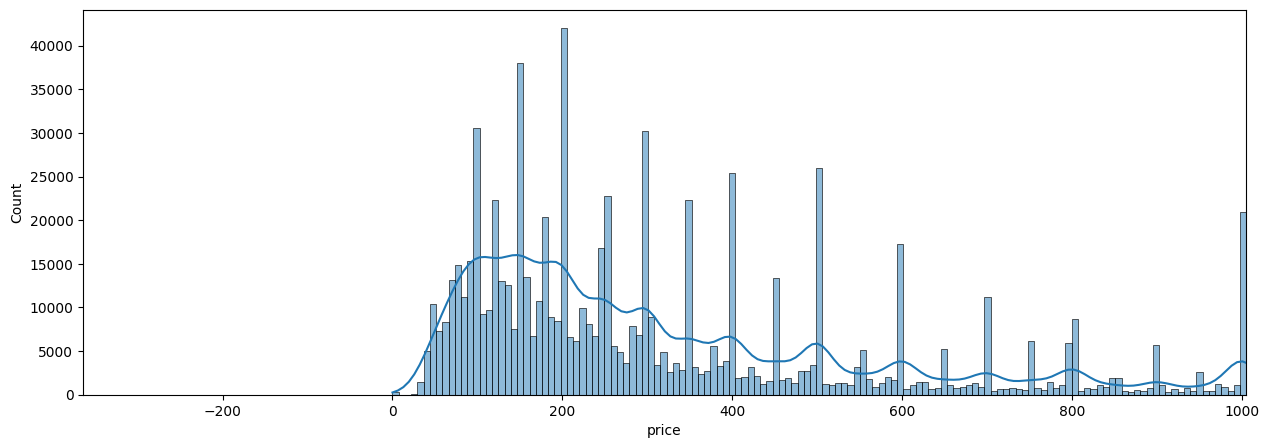

In [15]:
# COM as linha REMOVIDAS (os indices acima e abaixo do que preciso):
histograma(df_airbnb_copy['price'])
print(df_airbnb_copy.shape)

### Extra People

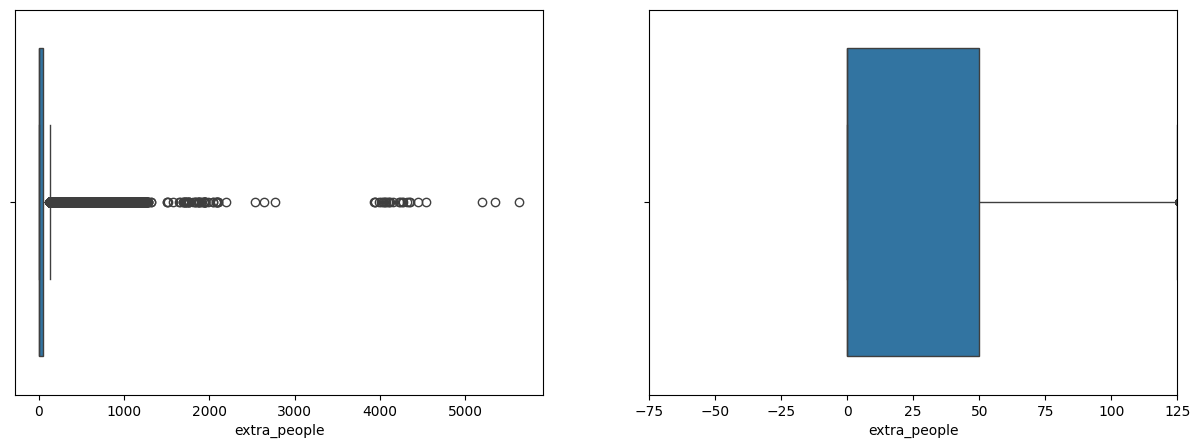

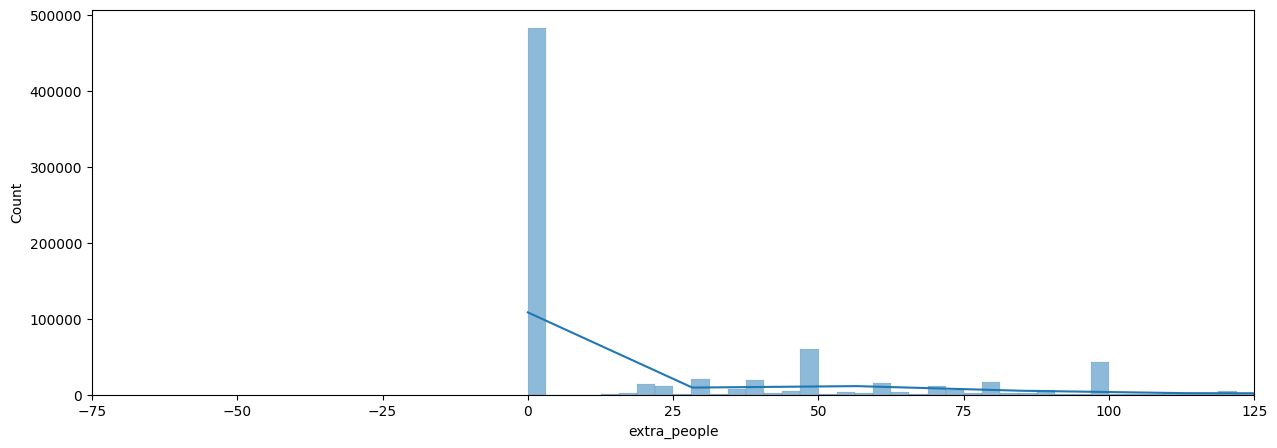

In [16]:
diagrama_caixa(df_airbnb_copy['extra_people'])
histograma(df_airbnb_copy['extra_people'])

In [17]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))
# coluna 'extra_people' ainda está como str (texto), a função quantile() não consegue calcular quartis com strings

59194 linhas removidas


(751233, 23)


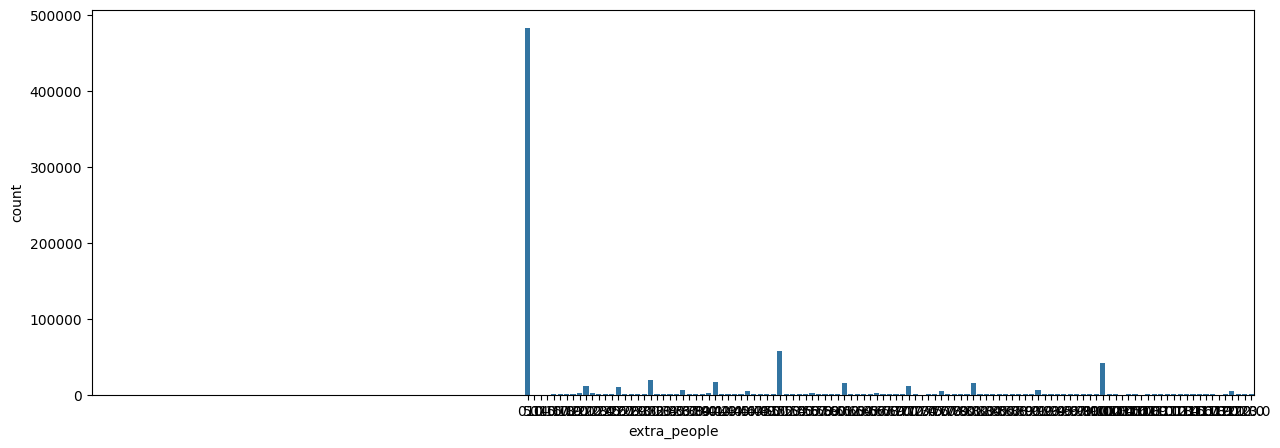

In [18]:
grafico_barra(df_airbnb_copy['extra_people'])
print(df_airbnb_copy.shape)

 1   host_listings_count...  float64<br>
 6   accommodates...         int64<br>
 7   bathrooms...            float64<br>
 8   bedrooms...             float64<br>
 9   beds...                 float64<br>
 13  guests_included...      int64<br>
 15  minimum_nights...       int64<br>
 16  maximum_nights...       int64<br>
 17  number_of_reviews...    int64<br>

### host_listings_count

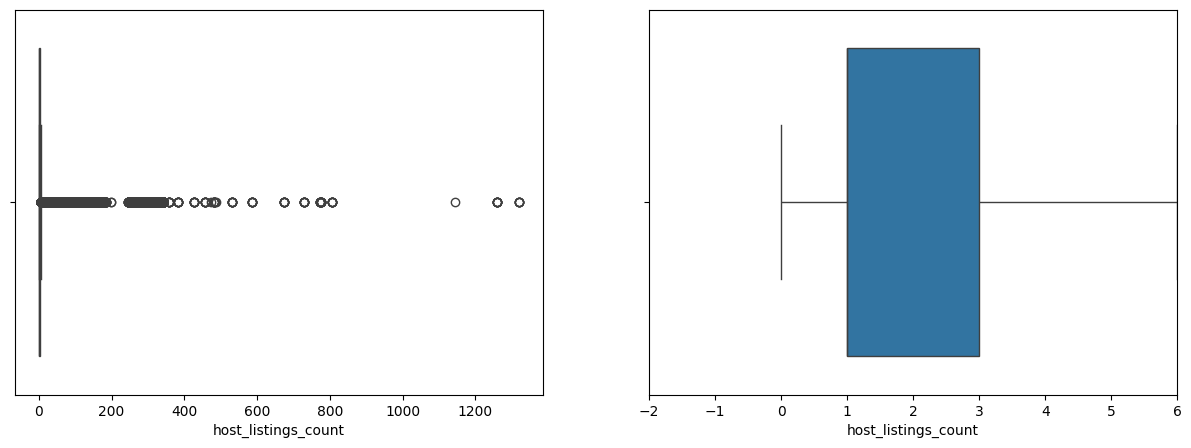

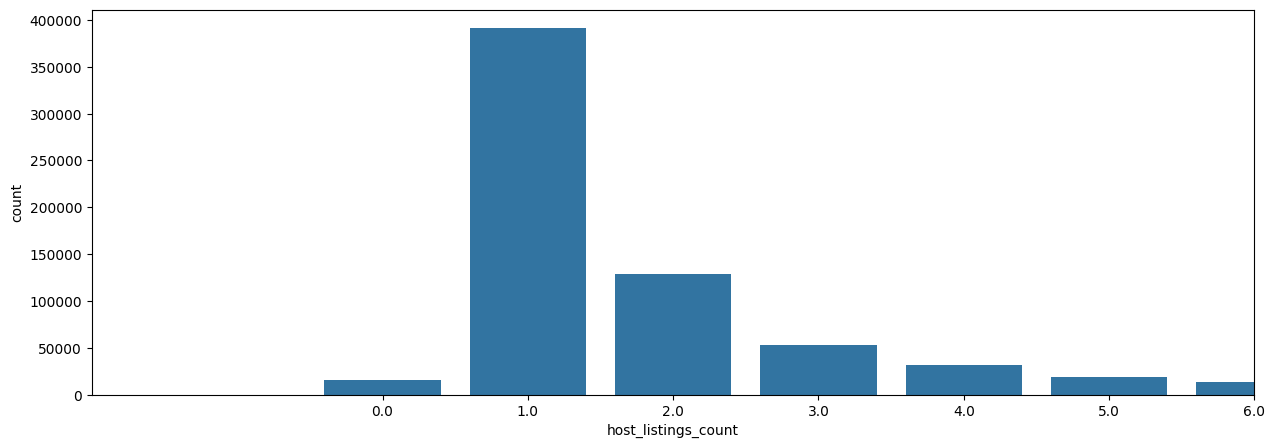

In [19]:
diagrama_caixa(df_airbnb_copy['host_listings_count'])
grafico_barra(df_airbnb_copy['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [20]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates:

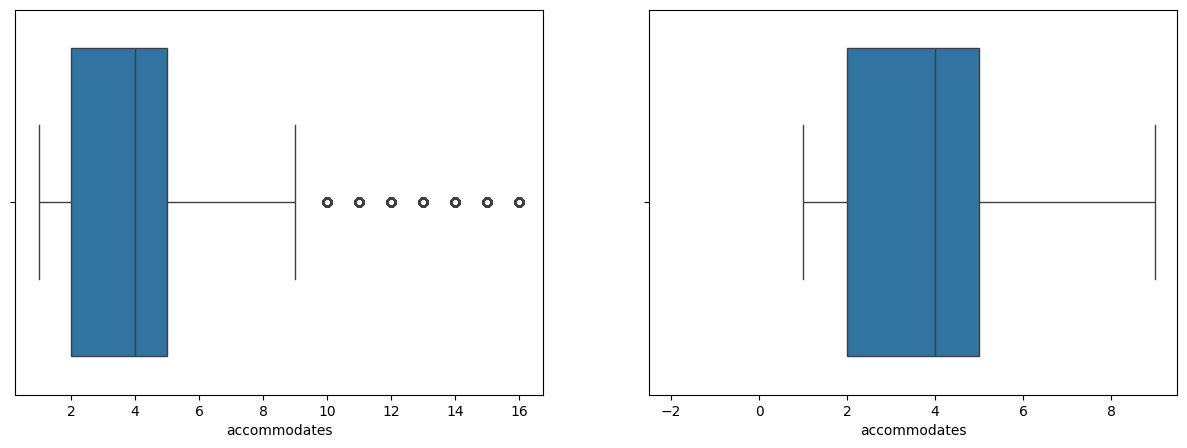

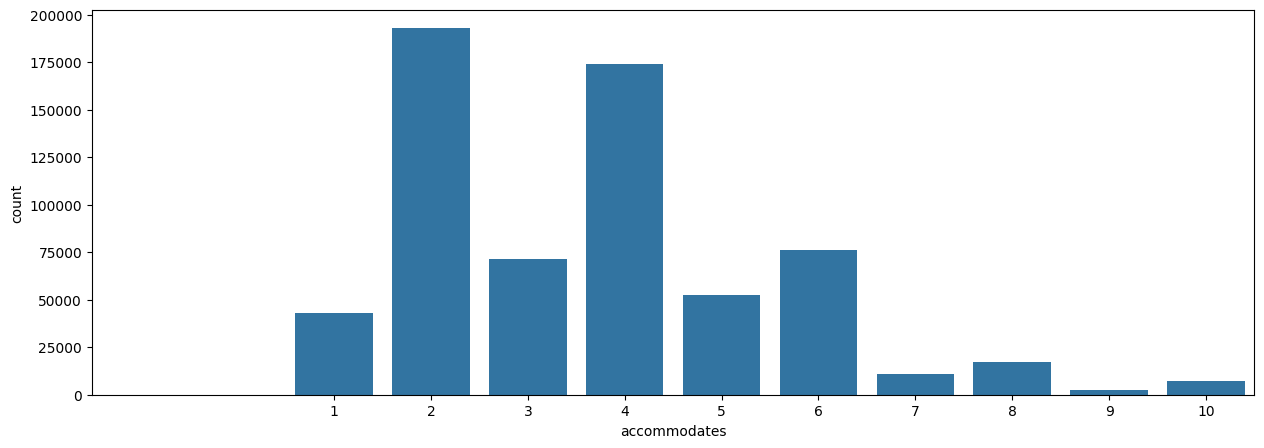

In [21]:
diagrama_caixa(df_airbnb_copy['accommodates'])
grafico_barra(df_airbnb_copy['accommodates'])

In [22]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))
print('Era para excluir 13146 linhas')

13146 linhas removidas
Era para excluir 13146 linhas


### bathrooms

<function matplotlib.pyplot.show(close=None, block=None)>

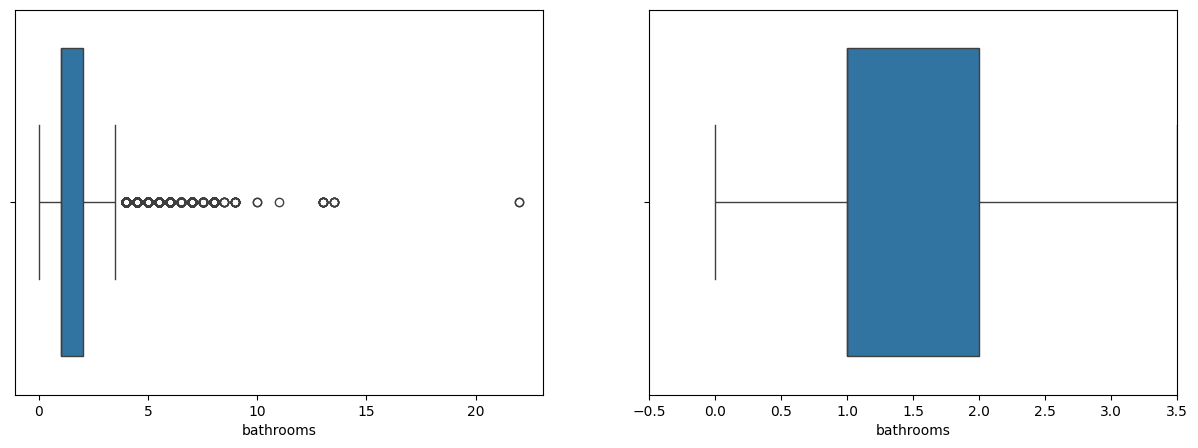

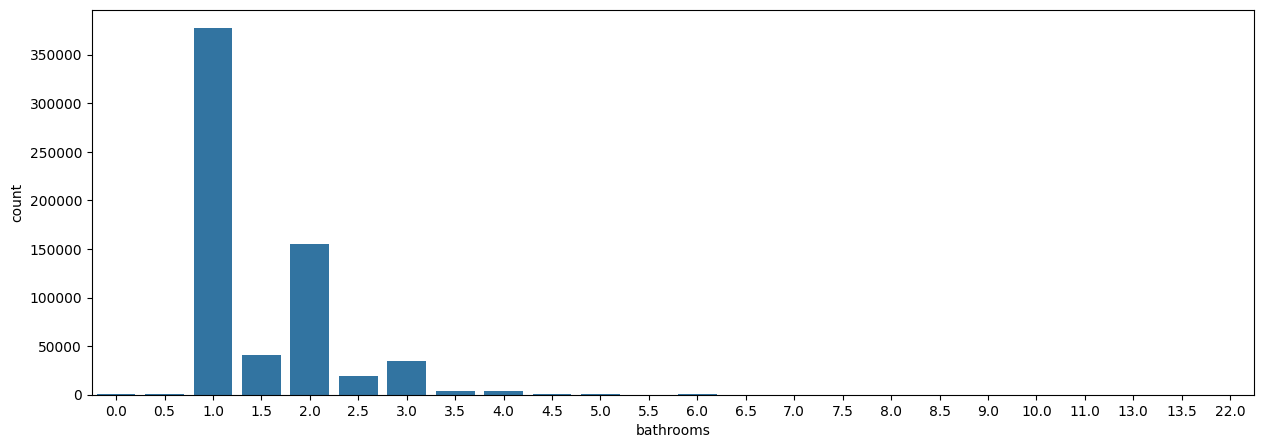

In [23]:
diagrama_caixa(df_airbnb_copy['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=df_airbnb_copy['bathrooms'].value_counts().index, y=df_airbnb_copy['bathrooms'].value_counts())
plt.show

In [24]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))
print('Era para excluir 6894 linhas')

6894 linhas removidas
Era para excluir 6894 linhas


### bedrooms

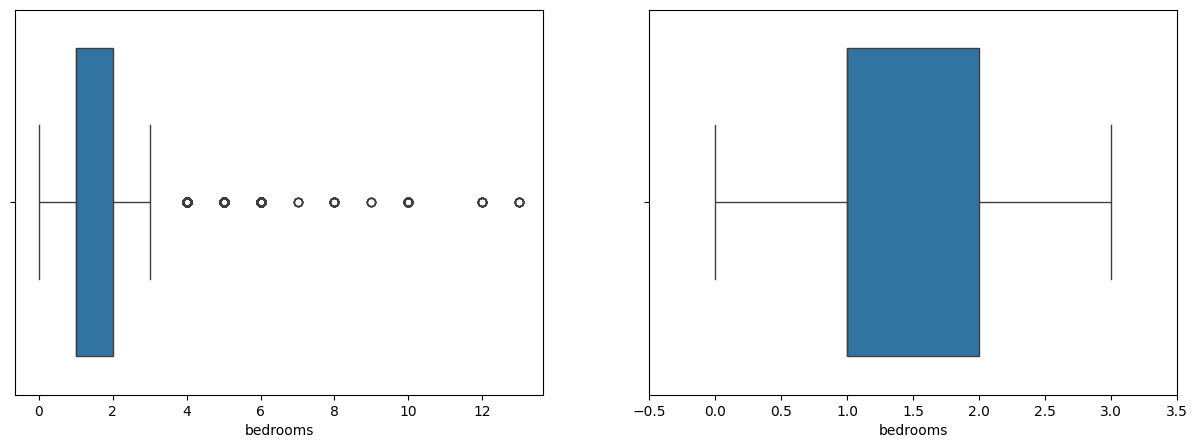

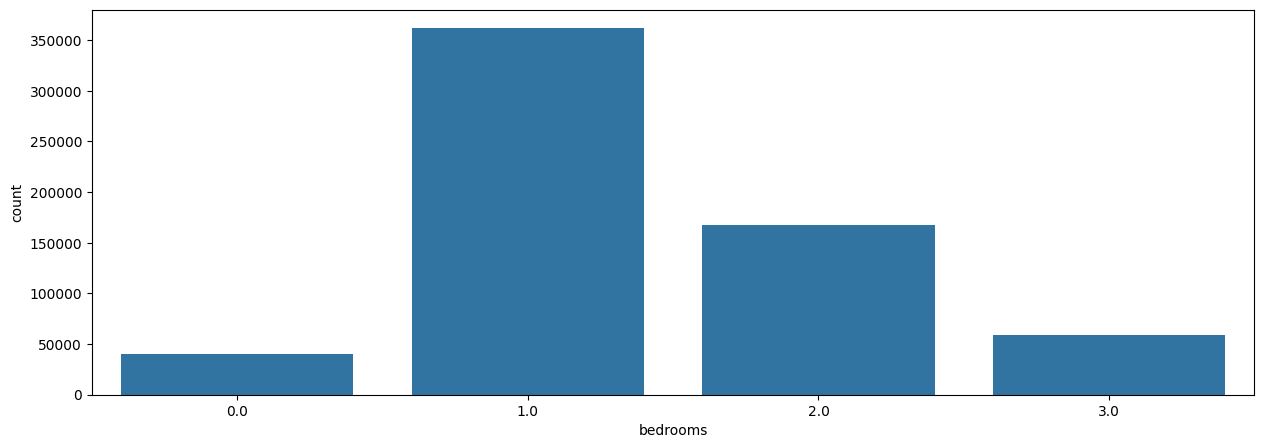

In [25]:
diagrama_caixa(df_airbnb_copy['bedrooms'])
grafico_barra(df_airbnb_copy['bedrooms'])

In [26]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))
print('Era para excluir 5482 linhas')

5482 linhas removidas
Era para excluir 5482 linhas


### beds

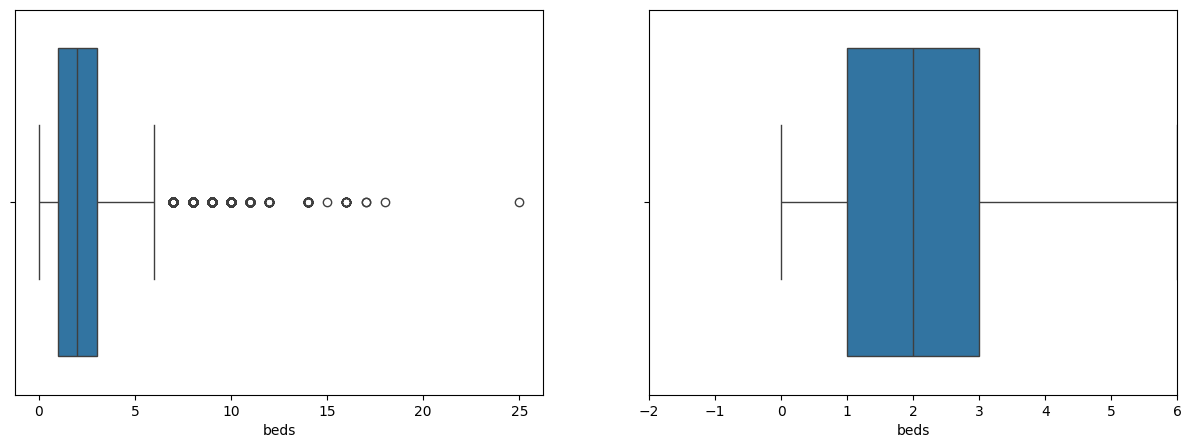

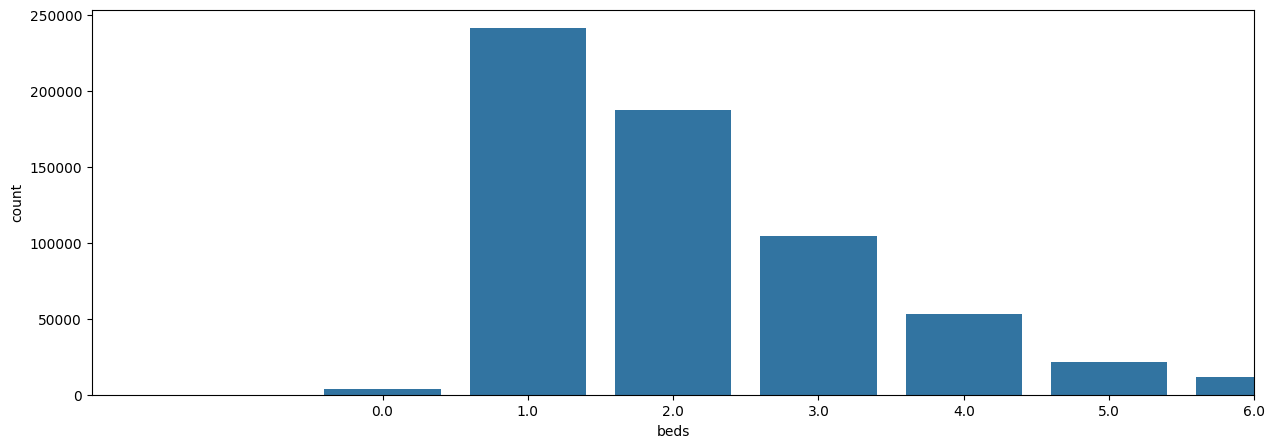

In [27]:
diagrama_caixa(df_airbnb_copy['beds'])
grafico_barra(df_airbnb_copy['beds'])

In [28]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'beds')
print('{} linhas removidas'.format(linhas_removidas))
print('Era para excluir 5622 linhas')

5622 linhas removidas
Era para excluir 5622 linhas


### guests_included

(np.float64(1.0), np.float64(1.0))


<function matplotlib.pyplot.show(close=None, block=None)>

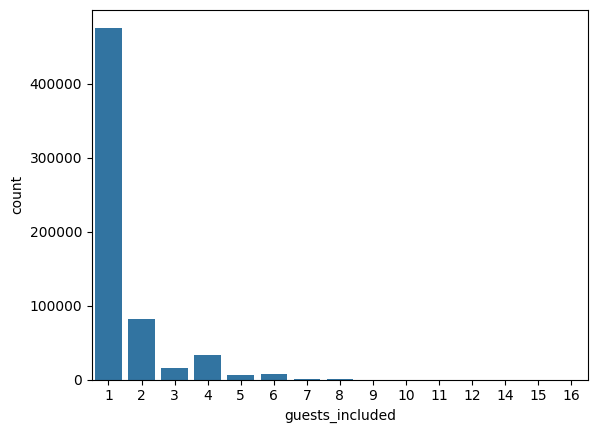

In [29]:
# quantas pessoas você paga a diária já estão inclusas no pacote:
# diagrama_caixa(df_airbnb_copy['guests_included'])
# grafico_barra(df_airbnb_copy['guests_included'])
print(limites(df_airbnb_copy['guests_included']))
sns.barplot(x=df_airbnb_copy['guests_included'].value_counts().index, y=df_airbnb_copy['guests_included'].value_counts())
plt.show

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [30]:
# Deletando a base guest_icluded pois é muito descrepante do que necessito:
df_airbnb_copy = df_airbnb_copy.drop('guests_included', axis=1)
print(df_airbnb_copy.shape)
print('resultado final: 622366, 22')

(622366, 22)
resultado final: 622366, 22


### minimum_nights

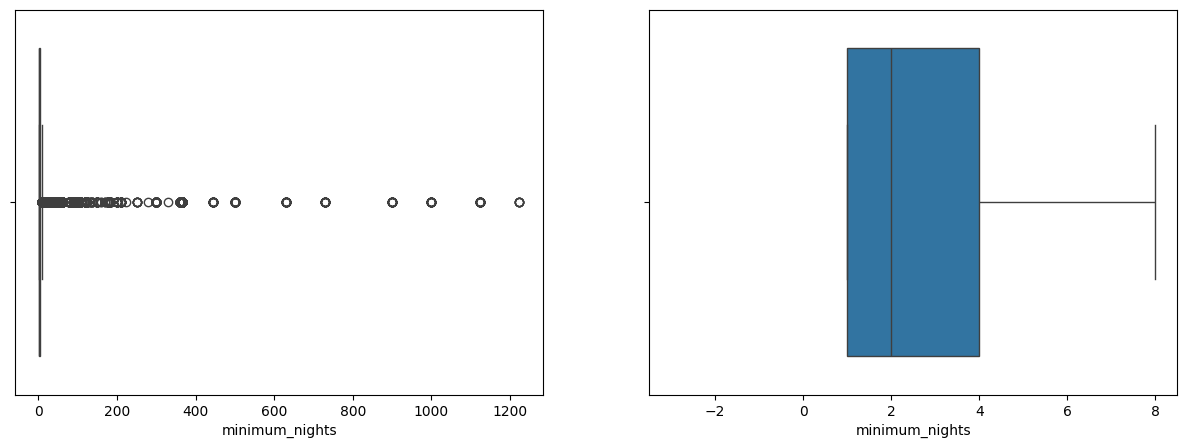

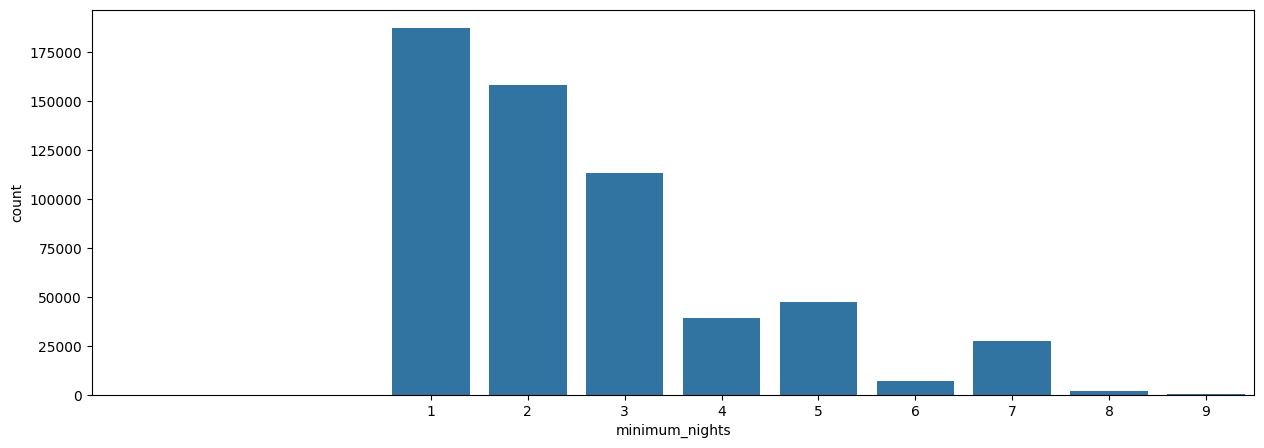

In [31]:
diagrama_caixa(df_airbnb_copy['minimum_nights'])
grafico_barra(df_airbnb_copy['minimum_nights'])

In [32]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))
print('Era para excluir 40383 linhas')

40383 linhas removidas
Era para excluir 40383 linhas


### maximum_nights

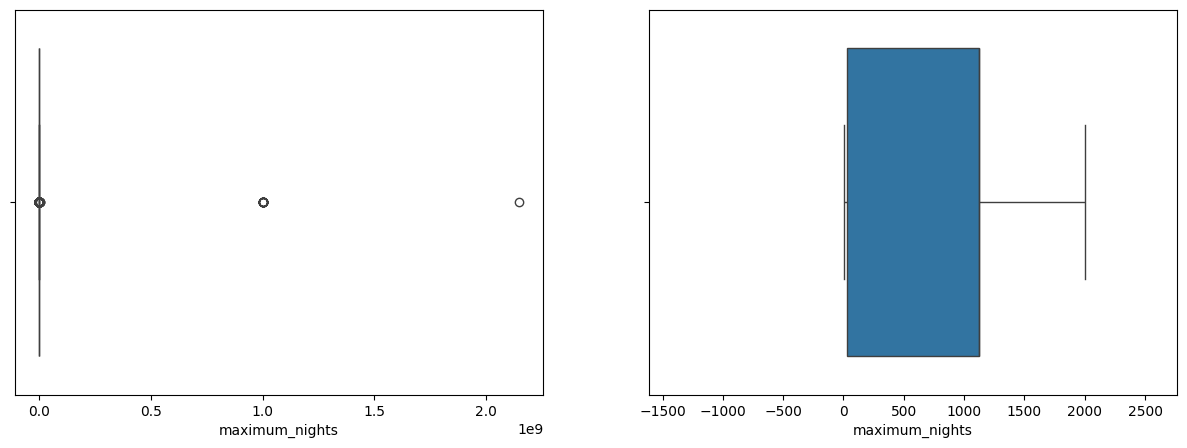

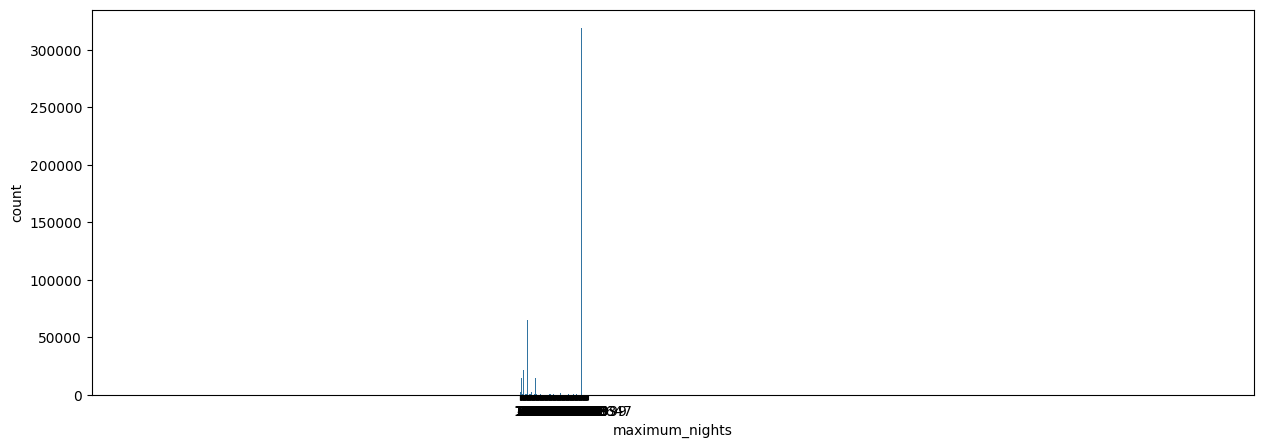

In [33]:
diagrama_caixa(df_airbnb_copy['maximum_nights'])
grafico_barra(df_airbnb_copy['maximum_nights'])

In [34]:
# Deletando a base maximum_nights pois é muito descrepante do que necessito:
df_airbnb_copy = df_airbnb_copy.drop('maximum_nights', axis=1)
print(df_airbnb_copy.shape)
print('resultado final: 581983, 21')

(581983, 21)
resultado final: 581983, 21


### number_of_reviews

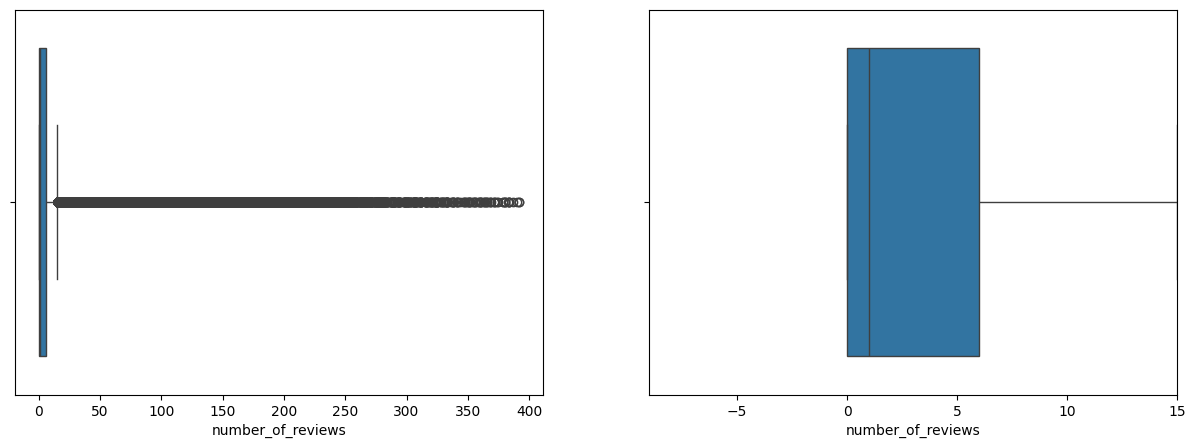

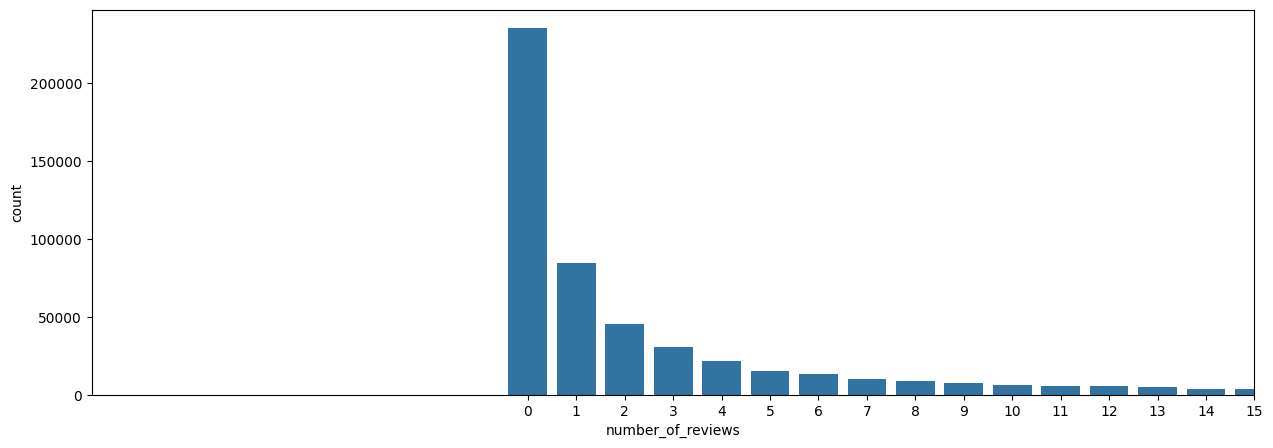

In [35]:
diagrama_caixa(df_airbnb_copy['number_of_reviews'])
grafico_barra(df_airbnb_copy['number_of_reviews'])

#### Quanto devemos precificar o imóvel que queremo inserir no ramo de alugar

In [36]:
# Deletando a base number_of_reviews pois é muito descrepante do que necessito:
df_airbnb_copy = df_airbnb_copy.drop('number_of_reviews', axis=1)
print(df_airbnb_copy.shape)
print('resultado final: 581983, 20')

(581983, 20)
resultado final: 581983, 20


property_type...          Apartment<br>
room_type...              Entire home/apt<br>
bed_type...               Real Bed<br>
amenities...              {TV,Internet,"Air conditioning",Kitchen,Doorma...<br>
cancellation_policy...    strict_14_with_grace_period<br>

### property_type

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

<function matplotlib.pyplot.show(close=None, block=None)>

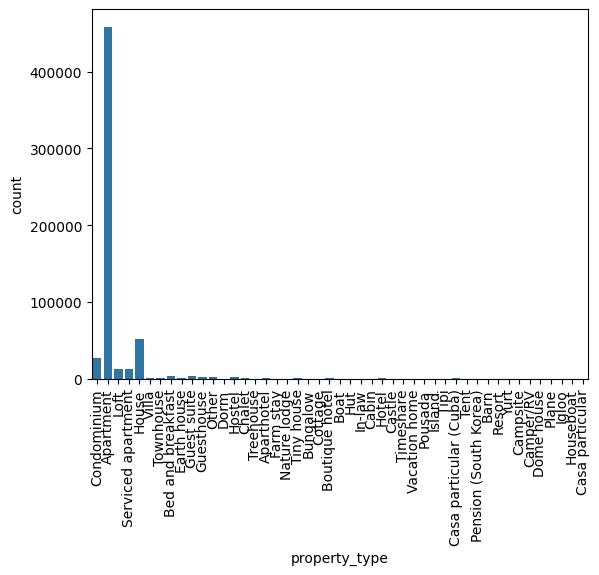

In [37]:
# property_type
print(df_airbnb_copy['property_type'].value_counts())
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='property_type', data=df_airbnb_copy)
plt.xticks(rotation=90)
plt.show

In [38]:
tabela_tipos_casa = df_airbnb_copy['property_type'].value_counts()
colunas_agrupar = []

colunas_agrupar = [tipo for tipo in tabela_tipos_casa.index if tabela_tipos_casa[tipo] < 2000]

for tipo in colunas_agrupar:
    df_airbnb_copy.loc[df_airbnb_copy['property_type'] == tipo , 'property_type'] = 'Outros'
print(df_airbnb_copy['property_type'].value_counts())

property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

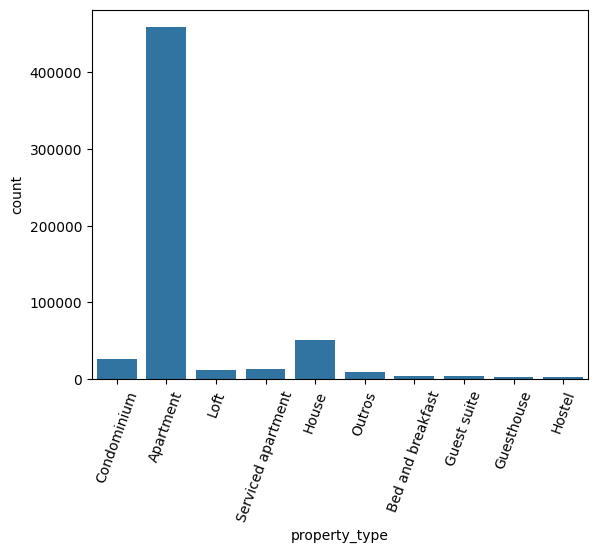

In [39]:
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='property_type', data=df_airbnb_copy)
plt.xticks(rotation=70)
plt.show

### room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

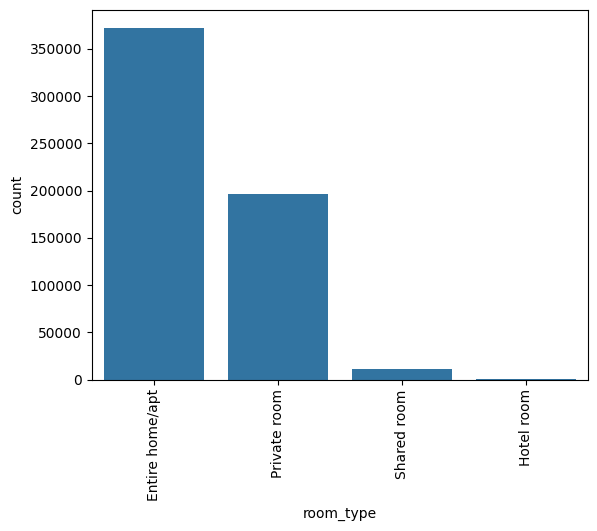

In [40]:
# room_type
print(df_airbnb_copy['room_type'].value_counts())
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='room_type', data=df_airbnb_copy)
plt.xticks(rotation=90)
plt.show

### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

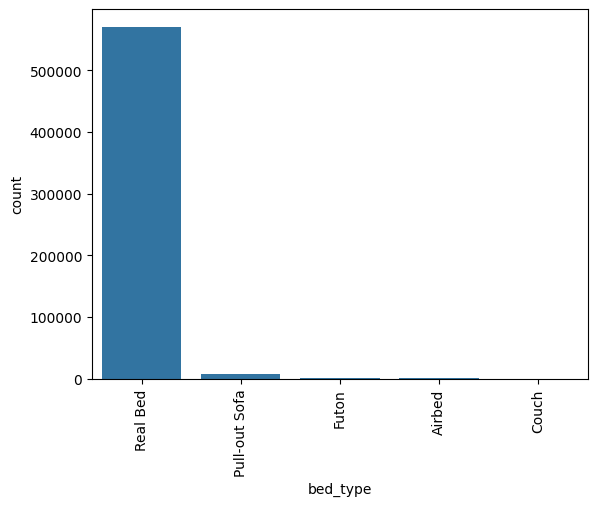

In [41]:
# bed_type
print(df_airbnb_copy['bed_type'].value_counts())
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='bed_type', data=df_airbnb_copy)
plt.xticks(rotation=90)
plt.show

bed_type
Real Bed        570643
Outras Camas     11340
Name: count, dtype: int64
bed_type
Real Bed        570643
Outras Camas     11340
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

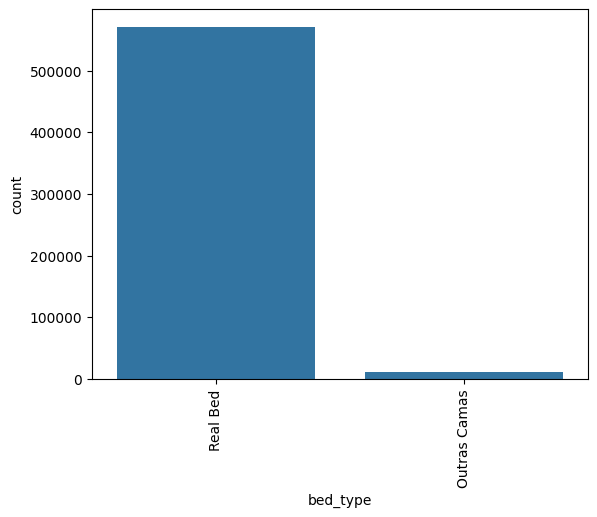

In [42]:
# Caso agrupe:
tabela_tipos_cama = df_airbnb_copy['bed_type'].value_counts()
colunas_agrupar = []

colunas_agrupar = [tipo for tipo in tabela_tipos_cama.index if tabela_tipos_cama[tipo] < 10000]

for tipo in colunas_agrupar:
    df_airbnb_copy.loc[df_airbnb_copy['bed_type'] == tipo , 'bed_type'] = 'Outras Camas'
print(df_airbnb_copy['bed_type'].value_counts())


# NO FINAL FICARÁ MAIS SUGESTIVO VERDADEIRO OU FALSO!


# bed_type agrupado:
print(df_airbnb_copy['bed_type'].value_counts())
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='bed_type', data=df_airbnb_copy)
plt.xticks(rotation=90)
plt.show

### amenities

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [43]:
print(df_airbnb_copy['amenities'].iloc[1].split(','))
print(len(df_airbnb_copy['amenities'].iloc[1].split(',')))

df_airbnb_copy['n_amenities'] = df_airbnb_copy['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [44]:
df_airbnb_copy = df_airbnb_copy.drop('amenities', axis=1)
df_airbnb_copy.shape

(581983, 20)

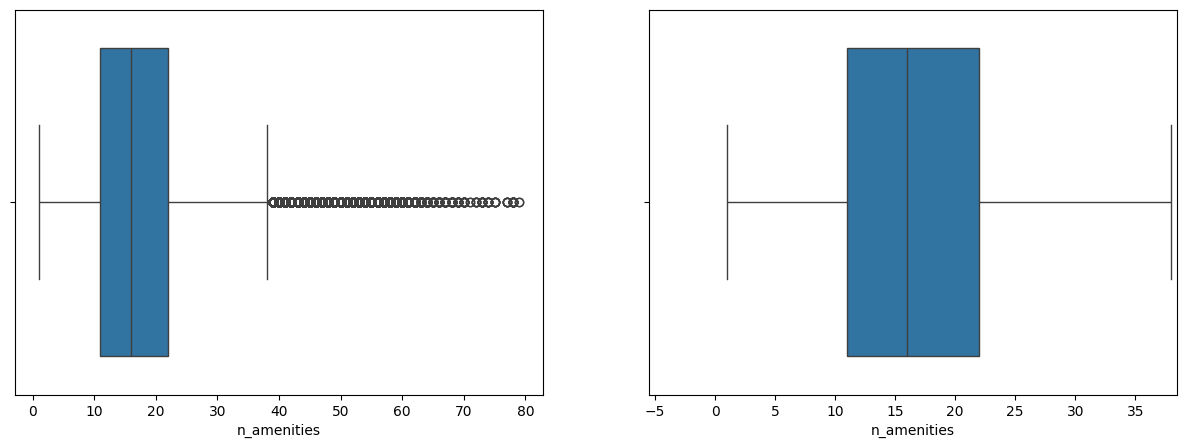

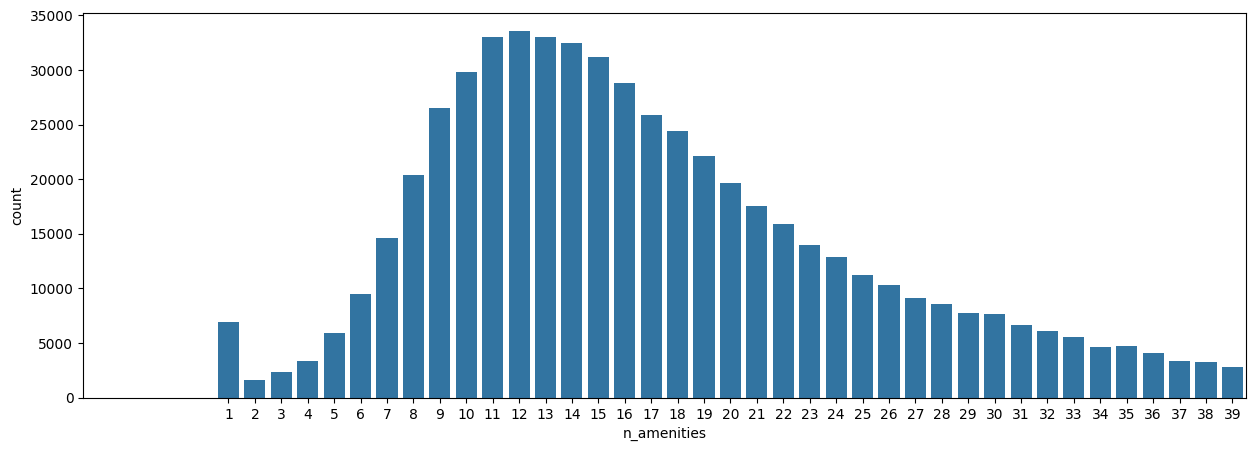

In [45]:
diagrama_caixa(df_airbnb_copy['n_amenities'])
grafico_barra(df_airbnb_copy['n_amenities'])

In [46]:
df_airbnb_copy, linhas_removidas = excluir_outliers(df_airbnb_copy, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))
print('Era para excluir 24343 linhas')

24343 linhas removidas
Era para excluir 24343 linhas


### cancellation_policy

cancellation_policy
flexible                       254039
strict_14_with_grace_period    189138
moderate                       104953
strict                           9343
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

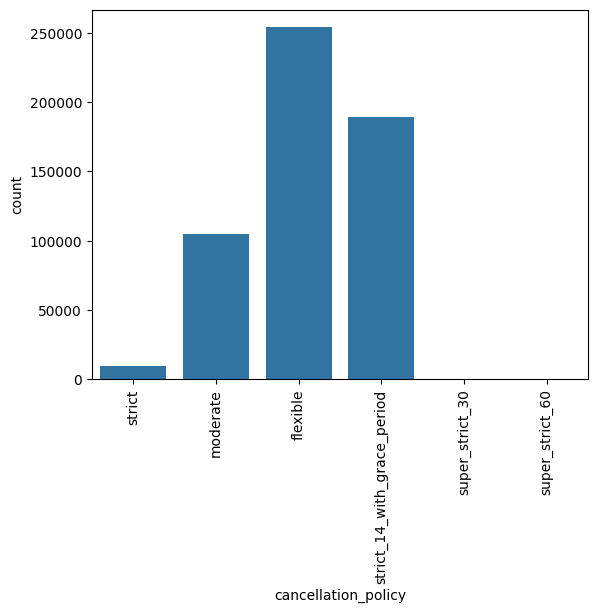

In [47]:
# cancellation_policy
print(df_airbnb_copy['cancellation_policy'].value_counts())
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='cancellation_policy', data=df_airbnb_copy)
plt.xticks(rotation=90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

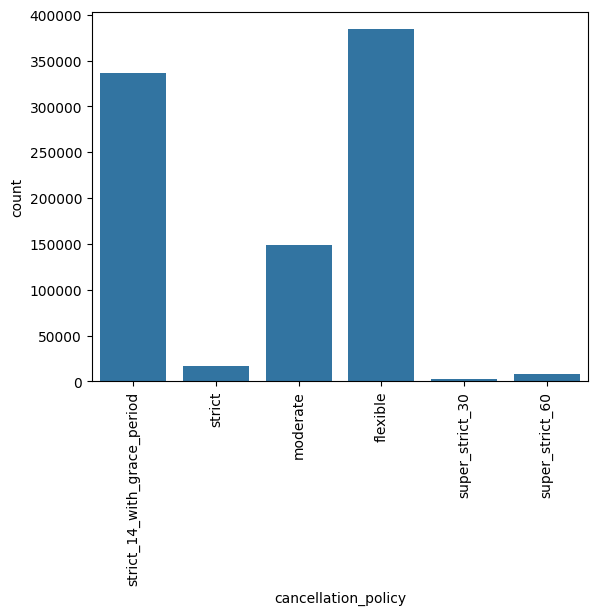

In [48]:
# Agrupando categorias de cancellation_policy:
tabela_cancelation = df_airbnb_copy['cancellation_policy'].value_counts()
colunas_agrupar = []

colunas_agrupar = [tipo for tipo in tabela_cancelation.index if tabela_cancelation[tipo] < 10000]

for tipo in colunas_agrupar:
    df_airbnb_copy.loc[df_airbnb_copy['cancellation_policy'] == tipo , 'cancellation_policy'] = 'Strict'

# cancellation_policy agrupada:
plt.Figure(figsize=(18, 6))
grafico = sns.countplot(x ='cancellation_policy', data=df_airbnb)
plt.xticks(rotation=90)
plt.show

### Visualização de Mapa das Propriedades

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [49]:
amostra = df_airbnb_copy.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_map(amostra,lat='latitude',lon='longitude',z='price',radius=2.5,
                      center=centro_mapa,zoom=10,map_style='open-street-map')

# map_style='stamen-terrain' = Exige API

mapa.show()

### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [50]:
print(df_airbnb_copy.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
price                       float32
extra_people                float32
minimum_nights                int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
n_amenities                   int64
dtype: object


In [51]:
tabela_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = df_airbnb_copy.copy()
for coluna in tabela_tf:
    base_airbnb_cod[coluna] = base_airbnb_cod[coluna].map({'t': 1, 'f': 0}).fillna(0).astype(int)

tabela_strings = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(base_airbnb_cod, columns=tabela_strings, drop_first=False)
# Converter todas as colunas booleanas para 1 e 0 (int)
bool_cols = base_airbnb_cod.select_dtypes(include='bool').columns
base_airbnb_cod[bool_cols] = base_airbnb_cod[bool_cols].astype(int)

print(base_airbnb_cod.dtypes)
display(base_airbnb_cod.head())

host_is_superhost                                    int64
host_listings_count                                float64
latitude                                           float64
longitude                                          float64
accommodates                                         int64
bathrooms                                          float64
bedrooms                                           float64
beds                                               float64
price                                              float32
extra_people                                       float32
minimum_nights                                       int64
instant_bookable                                     int64
is_business_travel_ready                             int64
mes                                                  int64
ano                                                  int64
n_amenities                                          int64
property_type_Apartment                              int

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outras Camas,bed_type_Real Bed,cancellation_policy_Strict,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,1,0,0,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,1,0,0,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,1,0,0,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,1,0,0,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,1,0,0,0


### Modelo de Previsão

- metricas de avaliação:

In [52]:
# Não consegue analisar texto, somente em números:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são bem bons para muitos problemas de Regressão.

In [53]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

print(X.iloc[0])

host_is_superhost                                     1.000000
host_listings_count                                   2.000000
latitude                                            -22.965919
longitude                                           -43.178962
accommodates                                          5.000000
bathrooms                                             1.000000
bedrooms                                              2.000000
beds                                                  2.000000
extra_people                                         51.000000
minimum_nights                                        4.000000
instant_bookable                                      1.000000
is_business_travel_ready                              0.000000
mes                                                   4.000000
ano                                                2018.000000
n_amenities                                          25.000000
property_type_Apartment                               0

- Separação os dados de TREINO e TESTE + TREINO DE MODELOS

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.23%
RSME:44.11
Modelo LinearRegression:
R²:32.70%
RSME:217.54
Modelo ExtraTrees:
R²:97.50%
RSME:41.90


- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

- Modelo RandomForest:<br>
    - R²: 0.9723468547350038<br>
    - RSME: 44.096734566202024<br>
<br>
- Modelo LinearRegression:<br>
    - R²: 0.3270168790140864<br>
    - RSME: 217.53855974042645<br>
<br>
- Modelo ExtraTrees:<br>
    - R²: 0.9749220326917822<br>
    - RSME: 41.99333135958649<br>


### Análise do Melhor Modelo

- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.

In [ ]:
# Rodas sempre o mais rápido, CASO ambos estejam com dados mais parecidos.

### Ajustes e Melhorias no Melhor Modelo

In [55]:
print(modelo_et.feature_importances_)
# Vai passar vários números, e mostrar a importância de cada coluna para o modelo. Vem no mesmo formato que o X_train(ordem)
print(X_train.columns)

importancia = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia = importancia.sort_values(by=0, ascending=False)
display(importancia)

[0.01319161 0.04003632 0.10382963 0.10144516 0.07833962 0.07382537
 0.10900602 0.05261647 0.08674422 0.0651932  0.02150396 0.
 0.00470512 0.01131982 0.08920546 0.01294292 0.00129339 0.00525481
 0.00068766 0.00094171 0.00063376 0.00715563 0.00221525 0.00236292
 0.00226497 0.06159435 0.00031017 0.00421607 0.00192613 0.00268402
 0.00271103 0.00082671 0.01932504 0.01207065 0.00762083]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'mes',
       'ano', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel r

,0
bedrooms,0.109006
latitude,0.103830
longitude,0.101445
n_amenities,0.089205
extra_people,0.086744
accommodates,0.078340
bathrooms,0.073825
minimum_nights,0.065193
room_type_Entire home/apt,0.061594
beds,0.052616


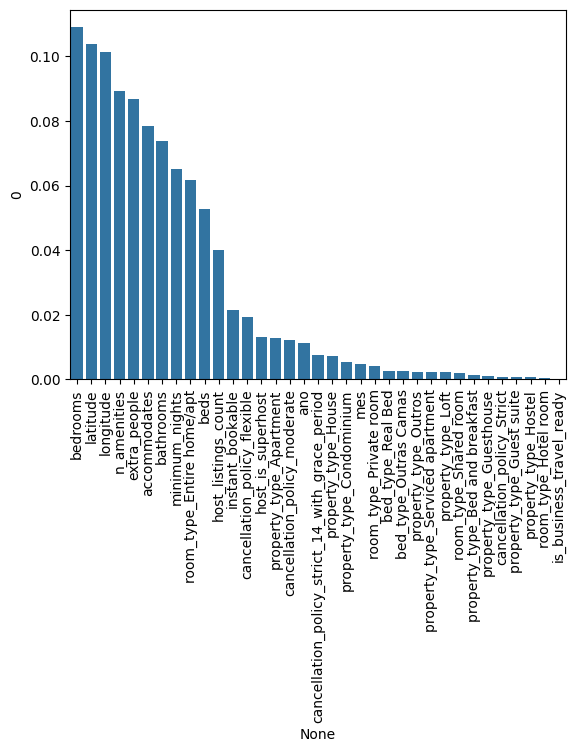

In [56]:
plt.Figure(figsize=(18, 6))
ax = sns.barplot(x=importancia.index, y=importancia[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [57]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.51%
RSME:41.88


In [58]:
base_teste = base_airbnb_cod.copy()

for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)

y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'mes', 'ano',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_Strict', 'cancellation_policy_flexible',
       'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R²:97.49%
RSME:42.00


- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>

- Modelo ExtraTrees:<br>
    - R²: 97.56%<br>
    - RSME: 41.46<br>

# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [59]:
# X são as características do nosso imóvel;
# Salvar a base de dados já limpa, 'tratado':

# Colocar novamente a coluna 'price' para no banco de dados:
X['price'] = y
X.to_csv('dados.csv', index=False, sep=';', encoding='latin-1')

In [60]:
import joblib

joblib.dump(modelo_et, 'modelo.joblib', compress=3)
# .dump = pega o objeto python e transforma em um arquivo;
# passar dois parâmetros: modelo e nome do arquivo;

['modelo.joblib']